## **MONAIによる3Dセグメンテーション入門**
MONAIによる3Dセグメンテーションの基本的な流れを紹介します。

使用したデータ
- [KiTS19 Grand Challenge](https://kits19.grand-challenge.org/)

処理の流れ
1. データの分割
2. データの前処理・データ拡張
3. モデルの学習
4. 推論結果の確認

In [1]:
#ライブラリのインポート
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    CenterSpatialCropd,
    SpatialPadd,
)
from monai.data import (
    CacheDataset,
    Dataset,
    DataLoader,
    load_decathlon_datalist,
    decollate_batch,
)

from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
import torch
import random
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter


#### **データ分割用jsonファイル作成**
データをトレーニング用とバリデーション用に分ける

In [29]:
N_data = 210
#the number of train data
N_train = np.round(N_data*0.8)
##the number of test data
N_test = N_data-N_train

dataroot = "/kqi/input/training/380/data"
data_json = {"training":[],"testing":[]}

for idx in range(N_data):
    
    image_path = dataroot + f"/case_{idx:05d}/imaging.nii.gz"
    mask_path = dataroot + f"/case_{idx:05d}/segmentation.nii.gz"
    pair_dir = {"image":image_path,"label":mask_path}
    
    if idx < N_train:
        data_json["training"].append(pair_dir)

    else:
        data_json["testing"].append(pair_dir)

        
dataset_path = '/kqi/output/data_list_pyfile.json'
with open(dataset_path, 'w') as f:
    json.dump(data_json, f)

実験のランダムな設定（モデルの初期パラメータなど）を固定し実験の再現性を保つ

In [4]:
#シード固定
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed=42
set_seed(seed)

#### **データの前処理・データ拡張**
- モデルに入力できるように画像を整える
- データにランダムな変換を加え、データの多様性を増やし**過学習**を防ぐための処理

In [27]:
#一度に切り出すパッチ数
NUM_SAMPLES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#ボクセルサイズ
PIXDIM = (1.5,1.5,1.5)
#ボリュームサイズ
IMAGE_SIZE = (128,256, 256)
#パッチサイズ
RAND_CROP_SIZE = (96,96,96)
LABEL_NAMES = {
               "kidney": 1,
               "tumor": 2}


train_transforms = Compose([
                    # 画像とラベルを読み込む
                    LoadImaged(keys=["image", "label"],image_only=False),
                    # 画像とラベルのチャンネルを最初に持ってくる
                    EnsureChannelFirstd(keys=["image", "label"]), #<class 'monai.data.meta_tensor.MetaTensor'>
                    # 画像の輝度を特定の範囲にスケーリングする（ウィンドウを-175から250の間に設定）
                    ScaleIntensityRanged(keys=["image"],a_min=-175,a_max=250,b_min=0.0,b_max=1.0,clip=True),
                    # 画像とラベルの空間解像度を指定されたピクセルサイズに変更
                    Spacingd(keys=["image", "label"],pixdim=PIXDIM,mode=("trilinear", "nearest")),
                    # 画像とラベルを指定された空間サイズにパディングする
                    SpatialPadd(keys=["image", "label"], spatial_size=IMAGE_SIZE),
                    # 中心を基準にして指定された空間サイズにクロップする
                    CenterSpatialCropd(keys=["image", "label"], roi_size=IMAGE_SIZE),
                     # 画像とラベルの向きをRAS（右・前・上）に合わせる
                    Orientationd(keys=["image", "label"], axcodes="RAS"),
                    # 前景、背景の比率に基づいてランダムにクロップを行う
                    RandCropByPosNegLabeld(
                        keys=["image", "label"],
                        label_key="label",
                        spatial_size=RAND_CROP_SIZE,
                        pos=1,
                        neg=1,
                        num_samples=NUM_SAMPLES,
                        image_key="image",
                        image_threshold=0,
                    ),
                    # 画像とラベルをx軸方向に10%の確率でランダムにフリップ
                    RandFlipd(
                        keys=["image", "label"],
                        spatial_axis=[0],
                        prob=0.10,
                    ),
                    # 画像とラベルをy軸方向に10%の確率でランダムにフリップ
                    RandFlipd(
                        keys=["image", "label"],
                        spatial_axis=[1],
                        prob=0.10,
                    ),
                    # 画像とラベルをz軸方向に10%の確率でランダムにフリップ
                    RandFlipd(
                        keys=["image", "label"],
                        spatial_axis=[2],
                        prob=0.10,
                    ),
                    # 90度ごとのランダムな回転を10%の確率で実行（最大3回）
                    RandRotate90d(
                        keys=["image", "label"],
                        prob=0.10,
                        max_k=3,
                    ),
                     # 画像の輝度をランダムにシフト（0.10のオフセット）し、50%の確率で実行
                    RandShiftIntensityd(
                        keys=["image"],
                        offsets=0.10,
                        prob=0.50,
                    ),
                ]
                )
    #output:torch.Size([2, 1, 96, 96, 96])

val_transforms = Compose(
                [
                    LoadImaged(keys=["image", "label"]),
                    EnsureChannelFirstd(keys=["image", "label"]),
                    ScaleIntensityRanged(
                        keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
                    ),
                    Spacingd(keys=["image", "label"],pixdim=PIXDIM,mode=("trilinear", "nearest")),
                    SpatialPadd(keys=["image", "label"], spatial_size=IMAGE_SIZE),
                    CenterSpatialCropd(keys=["image", "label"], roi_size=IMAGE_SIZE),
                    Orientationd(keys=["image", "label"], axcodes="RAS"),
                ]
            )

#トレーニングデータとバリデーションデータのパスを取得
train_files = load_decathlon_datalist(dataset_path, True, "training")
val_files = load_decathlon_datalist(dataset_path, True, "testing")
print(dataset_path)

#データセット、ローダーの作成
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, num_workers=4, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, num_workers=4, batch_size=1)

/kqi/output/data_list_pyfile.json


#### ※**CacheDataset**について
学習を高速に行いたい場合、**CacheDataset**を使用するとよい。
データの前処理のランダムでない変換までを行い、RAMにデータをキャッシュすることでデータローディングの時間を短縮できる。
自分のRAM容量に合わせて、キャッシュするデータの割合を指定できる。あまり多くキャッシュすると学習がクラッシュするため注意。
MONAI公式の学習時間の比較は[こちら](https://github.com/Project-MONAI/tutorials/blob/main/acceleration/dataset_type_performance.ipynb)。

In [ ]:
#データセット、ローダーの作成
train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=0.5)
val_ds = Dataset(data=val_files, transform=val_transforms)
train_loader = DataLoader(train_ds, num_workers=4, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, num_workers=4, batch_size=1)

データの確認

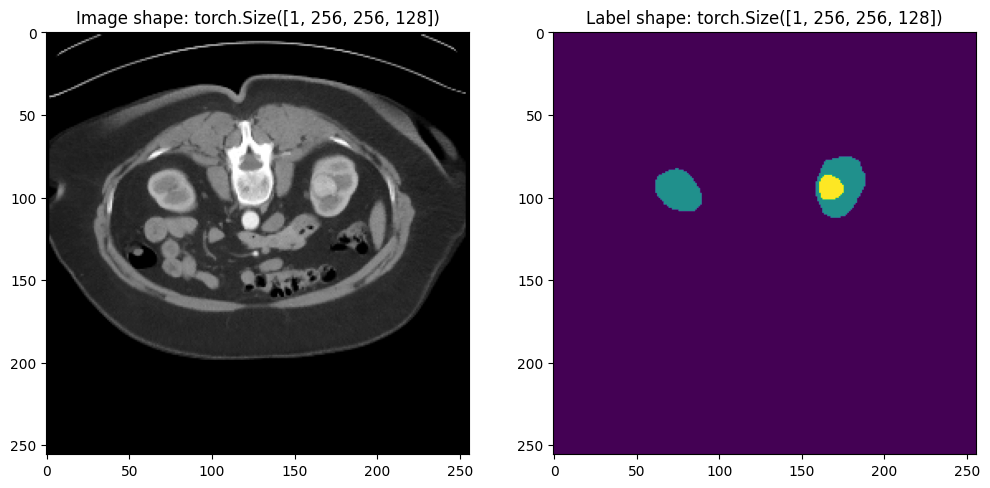

In [13]:
case_num = 6
slice_num = 40

img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img[0,:,:,slice_num].T.detach().cpu(), cmap="gray")
ax1.set_title(f'Image shape: {img.shape}')
ax2.imshow(label[0, :,:,slice_num].T.detach().cpu())
ax2.set_title(f'Label shape: {label.shape}')
plt.show()

#### **モデルの学習**

In [7]:
#実験設定
config = {

    "seed":seed,
    "num_workers": 4,
    "label_names":LABEL_NAMES,


    "train_batch_size": 1,
    "val_batch_size": 1,
    "lr": 1e-4,
    "max_epochs": 2,
    "rand_crop_num":NUM_SAMPLES,
    "image_size":IMAGE_SIZE,
    "voxel_size":PIXDIM,
    "val_interval":2,
    "sw_batch_size":2,
    "infer_device":"cpu",



    "model_type": "Swin-UNETR",
    "model_params": dict(
        image_size=RAND_CROP_SIZE,
        feature_size=48),
    "class_num":3,
}

In [28]:
#モデルの作成
MODEL = SwinUNETR(
    img_size=RAND_CROP_SIZE,
    in_channels=1,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,
)
MODEL = MODEL.to(DEVICE)

#事前学習モデルを使用する場合
#weight = torch.load("../net_params/model_swinvit.pt")
#MODEL.load_from(weights=weight)

#複数のGPUで学習を行いたい場合
#MODEL = torch.nn.DataParallel(MODEL)

In [40]:

class EarlyStopping:
    def __init__(self, patience=1, verbose=False, delta=0):
        """
        過学習を防ぐために早めに学習を止めるEarly stoppingのためのクラス。
        ただのパラメータの保存用にも使える
        """
        self.best_score = None
        self.current_score = None
        self.counter = 0
        self.patiece = patience
        self.delta = delta
        self.earlystop = False
        self.verbose = verbose
    def __call__(self, val_metric):
        self.current_score = val_metric

        if self.best_score == None:
            self.best_score = val_metric

        elif self.current_score - self.best_score > self.delta:
            self.best_score = self.current_score
            self.counter += 1
            if self.counter == self.patiece:
                self.earlystop = True
        

    def Print_score(self):
        if self.verbose == True:
            print(f"Val loss(Current):{self.current_score}")
            
    def set_false(self):
        self.earlystop = False
        self.counter = 0


#学習用ループ
class TrainLoop:
    def __init__(self,model,config,train_dataloader,val_dataloader,device,run_name="",infer_device="cpu"):
        self.model = model
        self.n_epochs = config["max_epochs"]
        self.lr = config["lr"]
        self.loss = DiceCELoss(to_onehot_y=True, softmax=True)
        self.optimizer = optim.AdamW(model.parameters(), lr=self.lr, weight_decay=1e-5)
        self.dice_metric = DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=False)
        self.scaler = torch.cuda.amp.GradScaler()
        self.train_loader = train_dataloader
        self.val_loader = val_dataloader
        self.device = device
        self.out_channels = config["class_num"]
        self.label_names = config["label_names"].keys()
        self.post_label = AsDiscrete(to_onehot=config["class_num"]) # class n
        self.post_pred = AsDiscrete(argmax=True, to_onehot=config["class_num"]) # class n
        self.sw_batch_num = config["sw_batch_size"]
        self.rand_crop_size = config["model_params"]["image_size"]
        self.val_interval = config["val_interval"]
        self.run_name = run_name
        self.infer_device = (infer_device if config["infer_device"] == "cpu" else self.device)
        self.early_stopping = EarlyStopping()
        self.writer = SummaryWriter(log_dir="/kqi/output/logs")
        
        
    
    def train(self,over_write=True):
        
        os.makedirs(f"./net_params/{self.run_name}",exist_ok=over_write)

        #エポックループ
        for epoch in tqdm(range(1,self.n_epochs+1)):
            #バリエーション実行時
            if epoch % self.val_interval == 0:
                train_mean_epoch_loss = self.train_epoch()
                val_mean_epoch_loss, val_dice_metrics = self.validate_epoch()

                print(f"【Epoch:{epoch}】\n Train loss:{train_mean_epoch_loss:.7f} \
                  \n Val loss:{val_mean_epoch_loss:.7f} Val dice score:{np.mean(val_dice_metrics):.7f}")

                #ログを記録
                self.writer.add_scalar("train/epoch loss",train_mean_epoch_loss,epoch)
                self.writer.add_scalar("val/epoch loss",val_mean_epoch_loss,epoch)
                self.writer.add_scalar("val/mean dice score",np.mean(val_dice_metrics),epoch)
                
                for label_name, val_dice in zip(self.label_names,val_dice_metrics):
                    self.writer.add_scalar(f"val/{label_name} dice score",val_dice,epoch)
            



                self.early_stopping(np.mean(val_dice_metrics))
                #モデル保存
                if self.early_stopping.earlystop == True:
                    print("--Model was saved!--")
                    torch.save(self.model.state_dict(),f"/kqi/output/net_params/{self.run_name}/SwinUNETR_{self.run_name}_bestmodel.pth")
                    self.early_stopping.set_false()
            else:
                train_mean_epoch_loss = self.train_epoch()
                print(f"【Epoch:{epoch}】\n Train loss:{train_mean_epoch_loss:.7f}")

        torch.save(self.model.state_dict(),f"/kqi/output/net_params/{self.run_name}/SwinUNETR_epoch{self.n_epochs}_{self.run_name}.pth")
        self.writer.close()
        
            
    #トレーニングエポック
    def train_epoch(self):
        self.model.train()
        epoch_loss = 0
        print("train loop")

        for idx, batch in enumerate(self.train_loader):
            print(f"train iter:{idx}")
            images = batch["image"].to(self.device)
            labels = batch["label"].to(self.device)
            
            with torch.cuda.amp.autocast():
                logit = self.model(images)
                loss = self.loss(logit, labels)
            
            epoch_loss += loss.item()

            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            self.scaler.step(self.optimizer)
            self.scaler.update()
        
            del images, labels, logit
            torch.cuda.empty_cache()
        
        mean_epoch_loss = epoch_loss / len(self.train_loader)

        return mean_epoch_loss
    
    #バリエーションエポック
    def validate_epoch(self):
        self.model.eval()
        epoch_loss = 0
        print("validation loop")
        
        with torch.no_grad():
            for idx, batch in enumerate(self.val_loader):
            
                images = batch["image"].to(self.device)
                labels = batch["label"].to(self.infer_device)
                
                with torch.cuda.amp.autocast():
                    #ボリュームをパッチごとに推論
                    logit = sliding_window_inference(images, self.rand_crop_size, self.sw_batch_num, self.model, device=self.infer_device)
                    logit = logit.cpu()
                    loss = self.loss(logit, labels)
                
                epoch_loss += loss.item()
                output_convert, labels_convert = self.convert_onehot(logit,labels)
                #評価指標計算
                self.dice_metric(y_pred=output_convert, y=labels_convert)
                
            
                del images, labels, logit,output_convert, labels_convert
                torch.cuda.empty_cache()
                
            mean_epoch_loss = epoch_loss / len(self.val_loader)
            dice_metric = self.dice_metric.aggregate().tolist()
            self.dice_metric.reset()
            

        return mean_epoch_loss, dice_metric
    
    #ラベルのone-hot encoding
    def convert_onehot(self, outputs, true_labels):
        labels_list = decollate_batch(true_labels)
        labels_convert = [self.post_label(label_tensor) for label_tensor in labels_list]
        outputs_list = decollate_batch(outputs)
        output_convert = [self.post_pred(pred_tensor) for pred_tensor in outputs_list]
        return output_convert, labels_convert


In [ ]:
#学習実行
RUN_NAME = "Swin-UNETR"
Trainer = TrainLoop(MODEL,config,train_loader,val_loader,DEVICE,run_name=RUN_NAME)
Trainer.train()

#### **推論結果の確認**

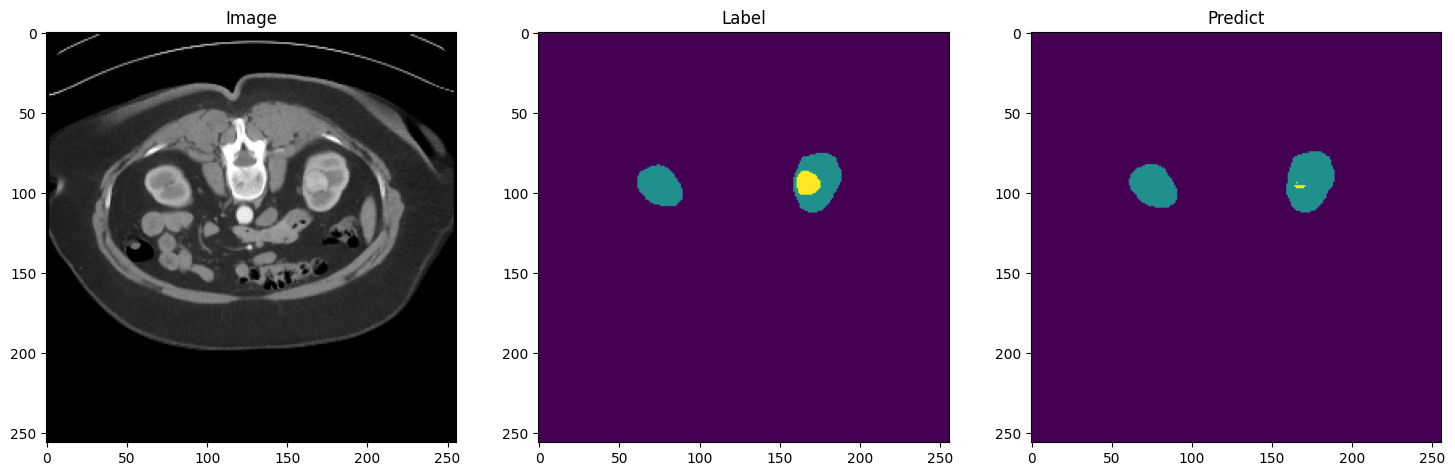

In [14]:
#学習時に複数のGPUを使った場合
MODEL = torch.nn.DataParallel(MODEL)
#学習時のパラメータをロード
MODEL.load_state_dict(torch.load("/kqi/parent/230/net_params/Swin-UNETR/SwinUNETR_epoch100_Swin-UNETR.pth"))
MODEL.eval()

case_num = 6
slice_num = 40

with torch.no_grad():
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, MODEL
    )
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num].T, cmap="gray")
    ax1.set_title('Image')
    ax2.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num].T)
    ax2.set_title(f'Label')
    ax3.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_num].T)
    ax3.set_title(f'Predict')
    plt.show()

In [30]:
#推論して評価指標を確認するコード
def make_resultdf(model, val_loader, device,run_name,patch_size=(96,96,96),sw_batch_size=2):
    os.makedirs(f"../results/{run_name}",exist_ok=True)
    class_list = {
        "kidney":[],
        "tumor":[]
    }

    dice_metric = DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=False)

    def convert_onehot(outputs, true_labels):
        post_label = AsDiscrete(to_onehot=18) # class n
        post_pred = AsDiscrete(argmax=True,to_onehot=18)
        labels_list = decollate_batch(true_labels)
        labels_convert = [post_label(label_tensor) for label_tensor in labels_list]
        outputs_list = decollate_batch(outputs)
        output_convert = [post_pred(pred_tensor) for pred_tensor in outputs_list]
        return output_convert, labels_convert



    model.eval()
    with torch.no_grad():
        for batch in val_loader:
        
            images = batch["image"].to(device)
            labels = batch["label"]
            
            with torch.cuda.amp.autocast():
                logit = sliding_window_inference(images, patch_size, sw_batch_size, model, device="cpu")
                output_convert, labels_convert = convert_onehot(logit,labels)
                
                dice_result = dice_metric(y_pred=output_convert, y=labels_convert)[0]
                for idx, class_name in enumerate(class_list.keys()):
                    value = dice_result[idx].item()
                    class_list[class_name].append(value)
    
    result_df = pd.DataFrame(data=[],columns=[])
    for class_name in class_list.keys():
        result_df[class_name] = class_list[class_name]
    
    result_df.to_csv(f"../results/{run_name}/result_df.csv")
    return result_df
